In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import cv2
import random
import sys
sys.path.append("src")
import sindy_utils as sindy
from datetime import datetime
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__() 
        self.encode = nn.Sequential(
            # encoder: N, 3, 404, 720
            nn.Conv2d(3, 16, 2), # N, 16, 403, 719
            nn.ReLU(),
            nn.Conv2d(16, 32, 2), # N, 32, 402, 718
            nn.ReLU(),
            nn.MaxPool2d((2,3), stride=(2,3)), # N, 32, 201, 239              -- pool --
            nn.Conv2d(32, 64, 4), # N, 64, 198, 236
            nn.ReLU(),
            nn.Conv2d(64, 96, 4), # N, 96, 195, 233
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2), # N, 96, 97, 116                       -- pool --
            nn.Conv2d(96, 128, 5), # N, 128, 93, 112
            nn.ReLU(),
            nn.Conv2d(128, 150, 5, stride=2, padding=1), # N, 150, 46, 55
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2), # N, 150, 23, 27                        -- pool --
            nn.Conv2d(150, 200, 9, stride=2), # N, 200, 8, 10
            nn.ReLU()
        )
        
        self.fc1 = nn.Linear(200*8*10,params['z_dim'])
        # Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
        # Input [-1, +1] -> use nn.Tanh    
        
        # note: encoder and decoder are not symmetric
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(200, 150, 4), # N, 150, 11, 13
            nn.ReLU(),
            nn.ConvTranspose2d(150, 128, 5, stride=(2,3), padding=(2,2), output_padding=(0,2)), # N, 128, 21, 39
            nn.ReLU(),
            nn.ConvTranspose2d(128, 96, 4, stride=2, padding=(1,0)), # N, 96, 42, 80
            nn.ReLU(),
            nn.ConvTranspose2d(96, 64, 8), # N, 64, 49, 87
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 8, stride=2, padding=(2,1), output_padding=(0,1)), # N, 32, 100, 179
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1), # N, 16, 201, 359
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=2, padding=1, output_padding=(1,1)), # N, 3, 404, 720
            nn.ReLU()
        )   
        
        self.fc2 = nn.Linear(params['z_dim'], 200*8*10)

    def forward(self, x, z, mode):
        '''
        x: input for encoder
        z: input for decoder
        mode: 
            'train' -> use encoded for decoder
            'test'  -> feed z in an get decoded
        
        '''
        if mode == 'train':
            encoded = self.encode(x)
            encoded = encoded.view(-1,200*8*10)
            encoded = self.fc1(encoded)

            decoded = self.fc2(encoded)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        else:
            encoded = torch.zeros(1)

            decoded = self.fc2(z)
            decoded = decoded.view(-1,200,8,10)
            decoded = self.decode(decoded)
        
        return encoded, decoded

    
def calculateSindy(z, Xi, poly_order, include_sine_param):
    z_new = z.detach().numpy()
    
    theta = torch.from_numpy(sindy.sindy_library(z_new, poly_order, include_sine=include_sine_param))
    
    dz_prediction = torch.matmul(theta, Xi).float()
    
    return dz_prediction

2021-12-28 11:46:58


### Loading the data and the model

In [17]:
# loading model
path_folder = 'results/v5/'

to_load = path_folder+'Ae_4000epoch_bs16_lr1e-5_z2_sindt05_poly5.pt'
autoencoder = torch.load(to_load)
autoencoder = autoencoder.cpu()

# load a train data
path_folder_data = 'results/v5/data/'
test_data = torch.load(path_folder_data + 'train_data.pt')
print('train data: ', len(train_data), len(train_data[0]), len(train_data[0][0]), len(train_data[0][0][0]), len(train_data[0][0][0][0]))
print('train data reading done!')

# load a validation data
validation_data = torch.load(path_folder_data + 'validation_data.pt')
print('validation data: ', len(validation_data), len(validation_data[0]), len(validation_data[0][0]), len(validation_data[0][0][0]), len(validation_data[0][0][0][0]))
print('validation data reading done!')

# loading test data
test_data = torch.load(path_folder_data + 'test_data.pt')
print('test data: ', len(test_data), len(test_data[0]), len(test_data[0][0]), len(test_data[0][0][0]), len(test_data[0][0][0][0]))
print('test data reading done!')


# load Xi
Xi = torch.load(path_folder + 'Xi_3002epoch_bs16_lr1e-05_z2_sindt01_poly4.pt')
print('Xi loaded succesfully!')


train data:  30 16 3 404 720
train data reading done!
validation data:  4 16 3 404 720
validation data reading done!
test data:  4 16 3 404 720
test data reading done!
Xi loaded succesfully!


In [3]:
def matrixToNorm(x, offset=0, factor=0.95):
    x = (x - x.min() + offset) / x.max() * factor
    return x

poly_order = 4
include_sine_param = False
threshold_sindy = 1000
until = 5                      # choose the number of prediction stepts, 1 step are number of batch_size frames



In [4]:
# use more than 16 frames to get Xi
def constructXi(data, zDim):
    '''
    input: data as a list with shape [len batch_size RGB hight width]
    return: Xi
    
    '''
    # processs the data
    z_tensor = torch.empty((0, zDim))
    data_len = len(data)
    for i in range(data_len):
        if i == 20:
            break
        z_tensor_tmp, _ = autoencoder(train_data[i], 0, mode='train')
        z_tensor = torch.cat((z_tensor, z_tensor_tmp), 0)
        if i % 5 == 0:
            print(i, z_tensor.shape)
        del z_tensor_tmp

    print(z_tensor.shape)
    
    dz_tensor = z_tensor[2:data_len]
    z_tensor = z_tensor[1:data_len-1]
    
    # calculate sindy and Xi for the data
    z = z_tensor.cpu().detach().numpy()
    dz = dz_tensor.cpu().detach().numpy()

    Theta = torch.from_numpy(sindy.sindy_library(z, poly_order, include_sine=include_sine_param))
    Xi = torch.from_numpy(sindy.sindy_fit(Theta, dz, threshold_sindy))
    
    return Xi

Xi = constructXi(train_data, zDim=2)

print(Xi)

print(z)
print(dz)
print(dz_predict)
print(dz_predict2)

print(recon2_pred_tensor[1].shape, len(recon2_pred_tensor))

### plotting images for the first glance

max recon_data 0.91593426
max of z_tensor 0.18115379
max of dz_tensor 0.10527244
max of dz_predict 0.27671888
One step


C:\Users\timok\AppData\Local\Temp/ipykernel_23500/1786507000.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Two steps with the same Xi


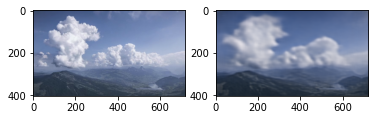

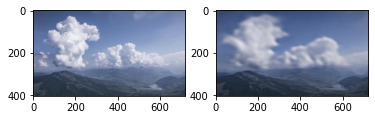

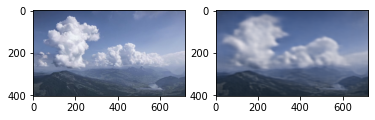

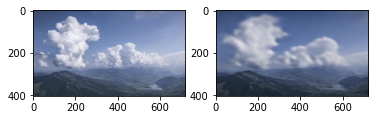

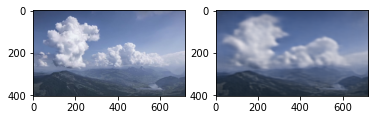

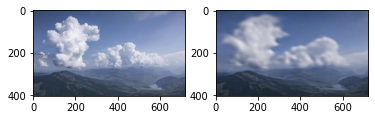

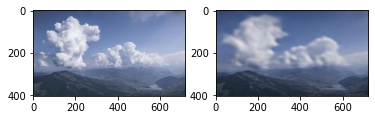

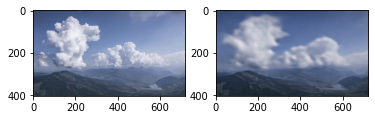

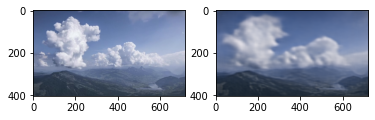

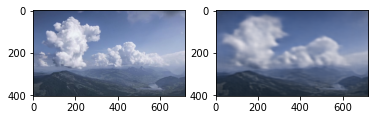

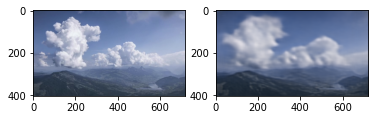

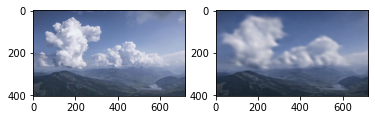

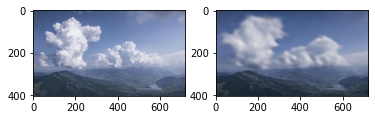

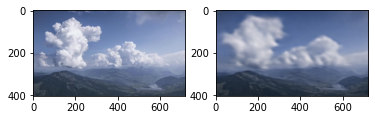

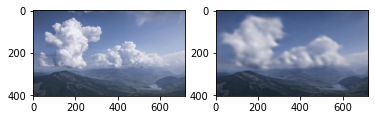

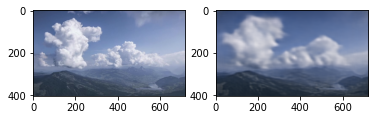

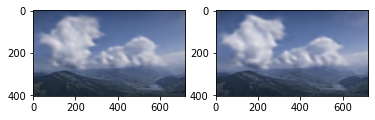

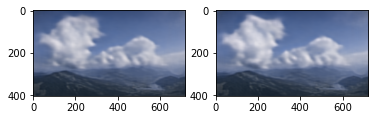

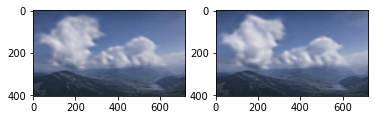

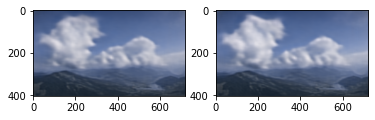

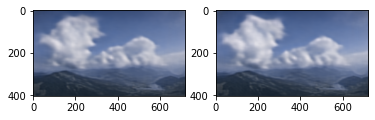

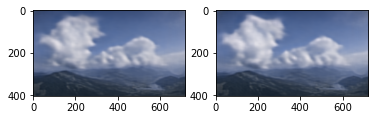

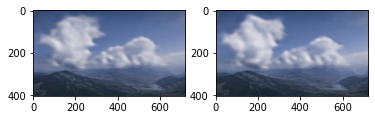

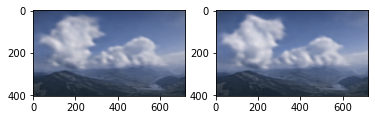

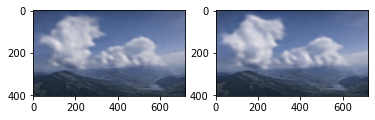

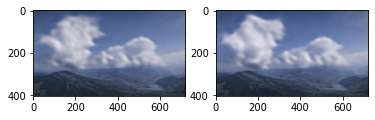

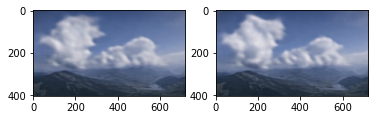

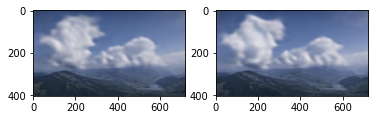

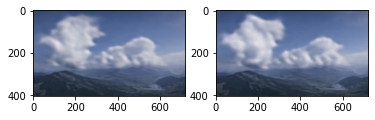

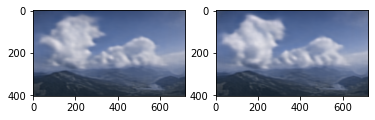

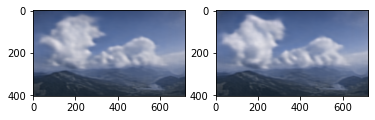

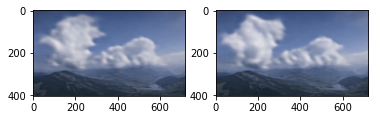

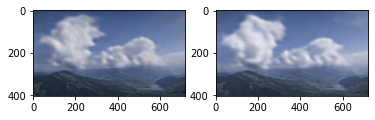

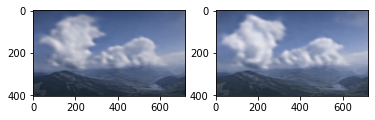

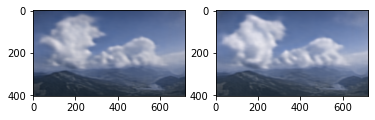

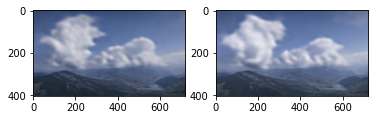

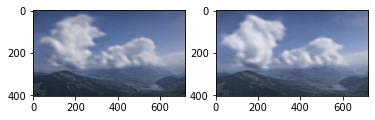

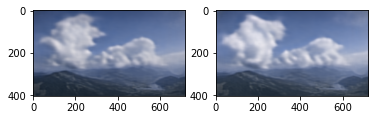

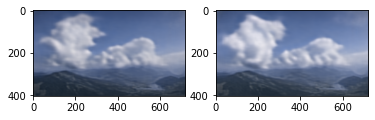

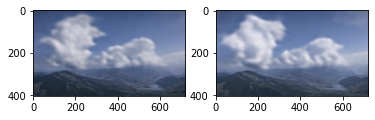

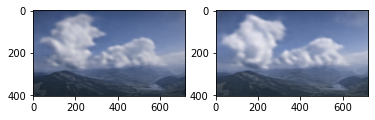

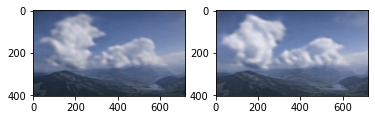

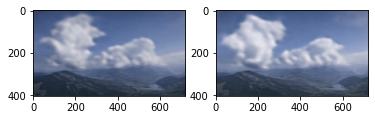

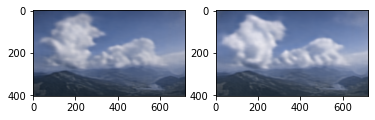

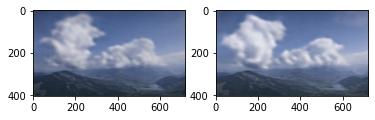

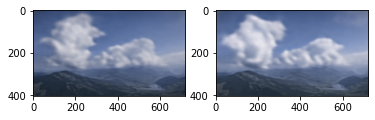

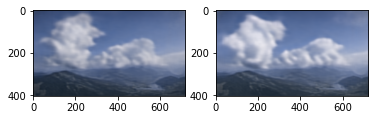

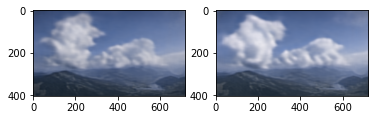

In [20]:
# get a Xi for only one picture, idea: mean of all Xi's with threshold
z_tensor, recon_tensor = autoencoder(test_data[0], 0, mode='train')
dz_tensor, recon1_tensor = autoencoder(test_data[1], 0, mode='train')

recon_tensor = matrixToNorm(recon_tensor)
print('max recon_data', recon_tensor.cpu().detach().numpy().max())


z = z_tensor.cpu().detach().numpy()
dz = dz_tensor.cpu().detach().numpy()

Theta = torch.from_numpy(sindy.sindy_library(z, poly_order, include_sine=include_sine_param))
dz_predict = torch.matmul(Theta, Xi).float()
_, recon1_pred_tensor = autoencoder(0, dz_predict, mode='test')
print('max of z_tensor', z_tensor.cpu().detach().numpy().max())
print('max of dz_tensor', dz_tensor.cpu().detach().numpy().max())
print('max of dz_predict', dz_predict.cpu().detach().numpy().max())

# plot autoencoder result
for nbImag in range(len(test_data[0])):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(test_data[0][nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon_tensor[nbImag].permute(1,2,0).detach().numpy())

print('One step')
recon1_tensor = matrixToNorm(recon1_tensor)
recon1_pred_tensor = matrixToNorm(recon1_pred_tensor)
# plot sindy result
for nbImag in range(len(recon1_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon1_tensor[nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon1_pred_tensor[nbImag].permute(1,2,0).detach().numpy())

# new calculations
dz_tensor, recon2_tensor = autoencoder(test_data[2], 0, mode='train')

Theta2 = torch.from_numpy(sindy.sindy_library(dz_predict, poly_order, include_sine=include_sine_param))
dz_predict2 = torch.matmul(Theta2, Xi).float()
_, recon2_pred_tensor = autoencoder(0, dz_predict2, mode='test')

print('Two steps with the same Xi')
recon2_tensor = matrixToNorm(recon2_tensor)
#for i in range(len(recon2_pred_tensor)):
#    recon2_pred_tensor[i] = matrixToNorm(recon2_pred_tensor[i])
for nbImag in range(len(recon2_tensor)):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(recon2_tensor[nbImag].permute(1,2,0).detach().numpy())
    plt.subplot(1,2,2)
    plt.imshow(recon2_pred_tensor[nbImag].permute(1,2,0).detach().numpy())



### Producing a video with sindy steps

In [18]:
until = 60

# test model
def test(data):
    video_reconstruction = []
    # predict videos
    # first step encode first batch
    img = data[0]
    encode_tensor, recon_tensor = autoencoder(img, 0, mode='train')
    
    # predict the future using only sindy model, new video starts always at position vid_nbr * until
    for i in range(0, until):
        print('pred', i)
        video_reconstruction.append(recon_tensor)
        dz_tensor = calculateSindy(encode_tensor, Xi, poly_order, include_sine_param)
        _, recon_tensor = autoencoder(0, dz_tensor, mode='test')
        encode_tensor = dz_tensor
            
    return video_reconstruction


video_output = test(test_data)
print('prediction done!')

#del test_data

pred 0
pred 1
pred 2
pred 3
pred 4
pred 5
pred 6
pred 7
pred 8
pred 9
pred 10
pred 11
pred 12
pred 13
pred 14
pred 15
pred 16
pred 17
pred 18
pred 19
pred 20
pred 21
pred 22
pred 23
pred 24
pred 25
pred 26
pred 27
pred 28
pred 29
pred 30
pred 31
pred 32
pred 33
pred 34
pred 35
pred 36
pred 37
pred 38
pred 39
pred 40
pred 41
pred 42
pred 43
pred 44
pred 45
pred 46
pred 47
pred 48
pred 49
pred 50
pred 51
pred 52
pred 53
pred 54
pred 55
pred 56
pred 57
pred 58
pred 59
prediction done!


In [24]:
# make videos
frame_width = len(video_output[0][0][0][0])
frame_height = len(video_output[0][0][0])
fps = 25.0
batch_size = 16

# write different videos
#forcc = cv2.VideoWriter_fourcc('M','J','P','G')
forcc = cv2.VideoWriter_fourcc('D','I','V','3')
#forcc = cv2.VideoWriter_fourcc('F','M','P','4')
out1 = cv2.VideoWriter('figures/run1_lre-5_z5_poly4/videoTest.avi', forcc, fps, (frame_width,frame_height))
#out2 = cv2.VideoWriter('video2.mov',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))
#out3 = cv2.VideoWriter('video3.mov',cv2.VideoWriter_fourcc('M','J','P','G'), fps, (frame_width,frame_height))


print('output video', len(video_output), len(video_output[0]), len(video_output[0][0]), len(video_output[0][0][0]), len(video_output[0][0][0][0]))

# undo batch structure
videoProcessing = []
count = -1
for img in range(0, len(test_data)*len(test_data[0])):
    imgIn_batch = img % batch_size
    # new batch
    if imgIn_batch == 0:
        count += 1
    img_toAppend = test_data[count][imgIn_batch]
    videoProcessing.append(img_toAppend)
        
#del video_output
print('video currently procession', len(videoProcessing), len(videoProcessing[0]), len(videoProcessing[0][0]), len(videoProcessing[0][0][0]))
    
for img in range(0,len(videoProcessing)):
    frame_local = np.transpose(videoProcessing[img].detach().numpy(), [1,2,0])
    frame_local = cv2.cvtColor(frame_local, cv2.COLOR_RGB2BGR)
    # print(frame_local) --> seems unstable, not a number and doesn't save it as a video
    out1.write(frame_local.shape)
    # show video
    cv2.imshow('Frame',frame_local)

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q') and img >= 10:
        break
    
    # Press w on keyboard to wait
    if cv2.waitKey(25) & 0xFF == ord('w'):
        while(True):
            if cv2.waitKey(25) & 0xFF == ord('e'):
                break
            

# When everything done, release the video capture and video write objects
out1.release()

# Closes all the frames
cv2.destroyAllWindows()

print('finished prediction video output!')

output video 60 16 3 404 720
video currently procession 64 3 404 720
finished prediction video output!


### questions
- Do I have that Xi regresses to the next state, now it is kind of a loop?